# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Actividad Semana 5

### **Vectores Embebidos de OpenAI**

#### **Nombres y matrículas de los integrantes del equipo:**



*   Eduardo Aldair Ahumada Garcia Jurado - A01422929
*   Ivan Troy Santaella Martinez - A01120515



In [42]:
# Aquí deberás incluir todas las librerías que requieras durante esta actividad:
import pandas as pd  
import numpy as np

import nltk
from nltk.corpus import stopwords
import re

from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nltk.download('punkt')    # es un tokenizador que ayuda a dividr el texto en enunciados mediante un modelo no-supervisado.
nltk.download('stopwords')    # para tener acceso a "stopwords" en varios idiomas.
nltk.download('averaged_perceptron_tagger_eng')   # es un etiquetador de partes del discurso (POS) para inglés.
nltk.download('wordnet')   # es un recurso léxico para el inglés que agrupa palabras en conjuntos de sinónimos (synsets) y proporciona definiciones y ejemplos de uso.

[nltk_data] Downloading package punkt to C:\Users\it-
[nltk_data]     user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\it-
[nltk_data]     user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\it-user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\it-
[nltk_data]     user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
# Incluye las celdas necesarias para tu acceso a la API de OpenAI.
import openai
import time
import pickle

import os
from dotenv import load_dotenv

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# **Pregunta - 1:**



Descarga los 3 archivos de Canvas y genera un nuevo DataFrame de Pandas con ellos.

**Llama simplemente "df" a dicho DataFrame.**

Los archivos los encuentras en Canvas: amazon5.txt, imdb5.txt, yelp5.txt.



In [44]:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

dfa = pd.read_csv('amazon5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')
dfy = pd.read_csv('yelp5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')

# *********** Aquí termina la sección de agregar código *************


In [45]:
# Abrimos el archivo imdb5.txt y lo procesamos por separado ya que no tiene el mismo formato que los otros archivos.
with open('imdb5.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# dividimos cada línea en dos partes: el texto de la reseña y la etiqueta
data = [line.rsplit(maxsplit=1) for line in lines]

# convertimos la lista de listas en un DataFrame
dfi = pd.DataFrame(data, columns=['review', 'label'])

In [46]:
df = pd.concat([dfa, dfi, dfy], ignore_index=True)
df['label'] = df['label'].astype(int)
print(df.shape)

(3000, 2)


In [47]:
# Verifiquemos la información del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [48]:
# Y veamos sus primeros registros:

df.head()

,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


# **Pregunta - 2:**

Realiza el proceso de limpieza. Aplica el preprocesamiento que consideres adecuado.











In [49]:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# Definimos una lista de stopwords que no incluya las palabras negativas para evitar que se eliminen
# en el preprocesamiento, ya que pueden ser importantes para la clasificación.
negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
mystopwords = set(stopwords.words('english')) - set(negwords)


In [50]:
# Separamos nuestro dataset en dos variables, X e Y, donde X contiene las reseñas y Y contiene las etiquetas.
X = df.review     
Y = df.label      

# Verificamos que la longitud de X e Y sean correctas.
assert X.shape == (3000,)
assert Y.shape == (3000,)

In [51]:
# Definimos una función para limpiar el texto de las reseñas.
def clean_tok(doc):
  # Remplazamos los caracteres de puntuación por espacios.
  doc = re.sub(r'[^A-Za-z0-9]', ' ', doc)
  # Separamos el texto en tokens.
  as_list = doc.split()
  # eliminamos los caracteres no alfabéticos y convertimos a minúsculas.
  as_list = [re.sub(r'[^A-Za-z]+', '', s).lower() for s in as_list]
  # eliminamos las palabras de longitud menor a 2.
  as_list = [x for x in as_list if len(x) > 1]
  # eliminamos las stopwords.
  as_list = [x for x in as_list if x not in mystopwords]
  tokens = as_list

  return tokens

In [52]:
# Aplicamos 2 procesos extras de limpieza:
# 1. Eliminamos los caracteres repetidos (ej: "loooove" -> "loove").
# 2. Lematizamos las palabras (ej: "running" -> "run").
# Definimos una lista de palabras que no queremos lematizar.
# Esto es útil para evitar lematizar pronombres y otras palabras que no cambian su forma.
do_not_lemmatize = {
    'i', 'me', 'my', 'mine', 'you', 'your', 'yours',
    'he', 'him', 'his', 'she', 'her', 'hers',
    'we', 'us', 'our', 'ours', 'they', 'them', 'their', 'theirs',
    'it', 'its'
}

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Función para eliminar caracteres repetidos.
def reduce_repeated_chars(word):
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def clean_doc(doc):
    # eliminamos caracteres repetidos.
    reduced = [reduce_repeated_chars(word) for word in doc]
    # inicializamos el lematizador.
    lemmatizer = WordNetLemmatizer()
    # obtenemos las etiquetas de parte de la oración.
    pos_tags = pos_tag(reduced) 
    # lematizamos las palabras según su etiqueta.
    lemmatized = []
    for word, tag in pos_tags:
        lower_word = word.lower()
        if lower_word in do_not_lemmatize:
            lemmatized.append(lower_word)
        else:
            lemma = lemmatizer.lemmatize(word, get_wordnet_pos(tag))
            lemmatized.append(lemma)

    tokens = lemmatized

    return tokens

In [53]:
# Aplicamos el proceso de limpieza y tokenización:
Xcleantok = [clean_tok(x) for x in X]   

# Aplicamos el proceso de limpieza/normalización adicionales:
Xclean = [clean_doc(x) for x in Xcleantok]  


In [54]:
Xclean[0:5]         # Veamos los primero registros para ver cómo va quedando el resultado.

[['no', 'way', 'plug', 'us', 'unless', 'go', 'converter'],
 ['good', 'case', 'excellent', 'value'],
 ['great', 'jawbone'],
 ['tie', 'charger', 'conversation', 'last', 'minute', 'major', 'problem'],
 ['mic', 'great']]

In [55]:
# *********** Aquí termina la sección de agregar código *************

# **Pregunta - 3:**



Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de
esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente.

In [56]:

# ************* Inicia la sección de agregar código:*****************************

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.70, shuffle=True, random_state=1) 
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)


# *********** Termina la sección de agregar código *************

# verificemos las dimensiones obtenidas:
print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


# **Pregunta - 4:**



Construye tu vocabulario a continuación


In [57]:
# a.	Usa el conjunto de entrenamiento para generar tu vocabulario
#     con un tamaño que consideres adecuado:


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

midiccionario = Counter()    

for k in range(len(x_train)):
  midiccionario.update(x_train[k])

# *********** Aquí termina la sección de agregar código *************

In [58]:
# b.	Indica el tamaño del vocabulario generado.

print('Longitud del vocabulario generado:')


# ******* Inicia la sección de agregar código: ***********

print('Longitud del diccionario:', len(midiccionario))  
print('\n(word,frequency):') 
print(midiccionario.most_common(10)) 

# *********** Aquí termina la sección de agregar código *************

Longitud del vocabulario generado:
Longitud del diccionario: 3421

(word,frequency):
[('not', 218), ('good', 178), ('great', 141), ('movie', 140), ('phone', 134), ('film', 130), ('work', 113), ('time', 101), ('one', 100), ('like', 98)]


In [59]:
# Filtramos el vocabulario para quedarnos con las palabras que aparecen al menos 3 veces en el conjunto de entrenamiento.
min_freq = 3

# filtramos el diccionario.
midicc = {word: freq for word, freq in midiccionario.items() if freq >= min_freq}

print('Nueva longitud del nuevo vocabulario:', len(midicc))
print(list(midicc.items())[0:5])     # veamos algunos elementos del diccionario.

Nueva longitud del nuevo vocabulario: 933
[('star', 18), ('don', 56), ('much', 39), ('good', 178), ('people', 23)]


c.	¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el vocabulario?


### ++++++++ Inicia la sección de agregar texto: +++++++++++

1. Evitar data leakage: Si se incluye información de los conjuntos de validación o prueba al construir el vocabulario, se corre el riesgo de que el modelo aprenda patrones específicos de esos conjuntos, lo que puede llevar a un sobreajuste y a una evaluación sesgada del rendimiento del modelo.
2. Evaluación realista: Al construir el vocabulario solo con el conjunto de entrenamiento, se asegura que la evaluación del modelo en los conjuntos de validación y prueba sea más representativa de su rendimiento en datos no vistos.
3. Generalización: Un vocabulario construido únicamente a partir del conjunto de entrenamiento ayuda a garantizar que el modelo se generalice mejor a nuevos datos, ya que no está influenciado por las características específicas de los conjuntos de validación o prueba.

### ++++++++ Termina la sección de agregar texto: +++++++++++


In [60]:
# d.	Con el vocabulario generado, filtra los conjuntos de entrenamiento,
#     validación y prueba para que todos los comentarios usen solamente las
#     palabras de este vocabulario.

#     Llamar train_x, val_x y test_x a estos tres conjuntos.


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


train_x = []
for ss in x_train:
  train_x.append([w for w in ss if w in midicc])

val_x = []
for ss in x_val:
  val_x.append([w for w in ss if w in midicc])

test_x = []
for ss in x_test:
  test_x.append([w for w in ss if w in midicc])


# *********** Aquí termina la sección de agregar código *************


In [61]:
# Vemos el resultado de los primeros comentarios del conjunto de entrenamiento:

for ss in train_x[0:5]:
  print(ss)

['star', 'don', 'much', 'good', 'people', 'like', 'ed', 'waste']
['special', 'suck']
['pay', 'bill', 'not', 'tip', 'felt', 'server', 'terrible', 'job']
['call', 'cook', 'steak', 'don', 'understand']
['however', 'keypad', 'tinny', 'sometimes', 'wrong', 'button']


# **Pregunta - 5:**


#### **Incluye aquí un resumen de las características y diferencias que tiene al menos los tres modelos de OpenAI indicados: "text-embedding-3-small", "text-embedding-3-large" y "text-embedding-ada-002".**

### ++++++++ Inicia la sección de agregar texto: +++++++++++

##### ***Comparativa de modelos de OpenAI para embeddings de texto:***
| Característica                          | `text-embedding-ada-002`               | `text-embedding-3-small`                                 | `text-embedding-3-large`                     |
| --------------------------------------- | -------------------------------------- | -------------------------------------------------------- | -------------------------------------------- |
| **Lanzamiento**                         | 2022                                   | Enero 2024                                               | Enero 2024                                   |
| **Generación**                          | 2ª generación                          | 3ª generación                                            | 3ª generación                                |
| **Dimensión del vector**                | Fija: 1536                             | Ajustable hasta 1536                                     | Ajustable hasta 3072                         |
| **Tokens de entrada**                   | 8191                                   | 8191                                                     | 8191                                         |
| **Precio por 1,000 tokens**             | \$0.0001                               | \$0.00002                                                | \$0.00013                                    |
| **Optimización**                        | General                                | Precisión/costo                                          | Máxima precisión                             |
| **Multilingüe**                         | Sí (limitado)                          | Sí (mejorado)                                            | Sí (superior)                                |
| **Soporte para reducción de dimensión** | No                                     | Sí                                                       | Sí                                           |
| **Benchmark MIRACL (multilingüe)**      | 31.4%                                  | 44.0%                                                    | 54.9%                                        |
| **Benchmark MTEB (tareas variadas)**    | 61.0%                                  | 62.3%                                                    | 64.6%                                        |
| **Casos de uso ideales**                | Búsqueda general, clasificación simple | Análisis de sentimientos, motores de búsqueda económicos | Recomendaciones, búsqueda semántica avanzada |
| **Ventaja clave**                       | Simplicidad y disponibilidad           | Balance costo/rendimiento                                | Precisión máxima y multilingüismo            |
| **Desventaja**                          | Menor precisión                        | Menor precisión que `3-large`                            | Más caro                                     |


##### ***Cuadro Comparativo: Ventajas, Desventajas y Casos de Uso***
| Modelo                     | Ventajas                                                                                                            | Desventajas                                                                                | Descripción / Casos de Uso Ideales                                                                                        |
| -------------------------- | ------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------- |
| **text-embedding-ada-002** | ✅ Bajo costo<br>✅ Dimensión razonable (1536)<br>✅ Bien probado en producción                                        | ❌ Menor precisión<br>❌ No permite reducir dimensiones<br>❌ Superado por modelos más nuevos | Ideal para prototipos, POCs y aplicaciones de bajo presupuesto que requieran embeddings decentes sin máxima precisión.    |
| **text-embedding-3-small** | ✅ Excelente relación costo/rendimiento<br>✅ Soporte para reducción de dimensión<br>✅ Precisión superior a `ada-002` | ❌ No alcanza el rendimiento máximo del modelo `3-large`                                    | Óptimo para la mayoría de aplicaciones productivas: clasificación, búsqueda semántica, análisis de sentimientos, etc.     |
| **text-embedding-3-large** | ✅ Mayor precisión<br>✅ Excelente rendimiento multilingüe<br>✅ Ideal para tareas complejas                           | ❌ Costo más alto<br>❌ Mayor dimensión base                                                 | Recomendado para motores de búsqueda críticos, recomendadores, RAG, NLP multilingüe y sistemas de atención al cliente AI. |

#### ***Recomendaciones de Uso***
- **text-embedding-3-large**: Para tareas que requieren la mayor precisión y soporte multilingüe avanzado, como motores de búsqueda semántica de alta calidad y sistemas de recomendación complejos.
    - Usa 3-large si: tu proyecto es crítico en precisión, involucra múltiples idiomas o necesitas máximo rendimiento en tareas semánticas.

- **text-embedding-3-small**: Para aplicaciones que buscan un equilibrio entre rendimiento y costo, como análisis de sentimientos, clasificación de contenido y búsqueda semántica eficiente.
    - Usa 3-small si: buscas precisión alta a bajo costo, con buena flexibilidad dimensional.

- **text-embedding-ada-002**: Para proyectos existentes que ya utilizan este modelo o cuando se requiere una solución probada y rentable, aunque con menor rendimiento en comparación con los modelos más recientes.
    - Usa ada-002 si: tu prioridad es el costo más bajo y no necesitas la mejor precisión.

### ++++++++ Termina la sección de agregar texto: +++++++++++


# **Pregunta - 6:**


#### **Diccionario clave-valor de palabras del diccionario y vectores embebidos.**

In [62]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

embedding_path = "embedding_dict.pkl"

# Si el archivo existe, lo cargamos. Si no, lo generamos y guardamos.
if os.path.exists(embedding_path):
    with open(embedding_path, "rb") as f:
        embedding_dict = pickle.load(f)
    print("Embeddings cargados desde archivo.")
else:
    words = list(midicc.keys())
    embedding_dict = {}
    i = 0
    for word in words:
        try:
            response = openai.embeddings.create(
                input=word,
                model="text-embedding-3-small"
            )
            embedding = response.data[0].embedding
            embedding_dict[word] = embedding
            i += 1
            # Imprimimos el progreso cada 100 palabras
            if i % 100 == 0:
                print(f"Progreso: {i}/{len(words)} palabras procesadas.")
            time.sleep(0.1)  # Para evitar rate limits
        except Exception as e:
            print(f"Error con la palabra '{word}': {e}")
    # Guardamos el diccionario en un archivo pickle
    with open(embedding_path, "wb") as f:
        pickle.dump(embedding_dict, f)
    print("Embeddings generados y guardados en archivo.")

# Ahora embedding_dict tiene la estructura {word: embedding_vector}


# *********** Aquí termina la sección de agregar código *************

Embeddings cargados desde archivo.


In [63]:
print("Tamaño del diccionario de embeddings:", len(embedding_dict))
print("Primeras 5 palabras y sus embeddings:")
for word, embedding in list(embedding_dict.items())[:5]:
    print(f"{word}: {embedding[:5]}...")  # Mostramos solo los primeros 5 valores del embedding


Tamaño del diccionario de embeddings: 933
Primeras 5 palabras y sus embeddings:
star: [-0.013770227320492268, -0.012703923508524895, -0.020466158166527748, -0.02024831250309944, -0.013804624788463116]...
don: [0.020259618759155273, -0.03061453439295292, 0.011888456530869007, 0.012978818267583847, 0.02128666825592518]...
much: [0.030653979629278183, -0.03788820654153824, 0.010267253965139389, 0.052722591906785965, -0.0006658936617895961]...
good: [0.0023704110644757748, 0.006724473088979721, -0.019609607756137848, 0.02746170200407505, 0.03913670778274536]...
people: [0.04156694561243057, -0.03560338169336319, 0.007150345481932163, 0.07280891388654709, 0.038362644612789154]...


# **Pregunta - 7:**



Generamos los vectores embebidos a partir de los conjuntos de entrenamiento, validación y prueba.

Los llamaremos trainEmb, valEmb y testEmb, respectivamente.

In [64]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

def comment_to_embedding(comment, embedding_dict, dim):
    vectors = [embedding_dict[w] for w in comment if w in embedding_dict]
    if len(vectors) == 0:
        return np.zeros(dim)  # O puedes usar np.nan o alguna otra estrategia
    return np.mean(vectors, axis=0)

# Obtén la dimensión de los embeddings
embedding_dim = len(next(iter(embedding_dict.values())))

trainEmb = np.array([comment_to_embedding(comment, embedding_dict, embedding_dim) for comment in train_x])
valEmb   = np.array([comment_to_embedding(comment, embedding_dict, embedding_dim) for comment in val_x])
testEmb  = np.array([comment_to_embedding(comment, embedding_dict, embedding_dim) for comment in test_x])


# *********** Aquí termina la sección de agregar código *************

In [65]:
# Veamos las dimensiones de cada conjunto embebido:

print("Train-Emb:", trainEmb.shape)
print("Val-Emb:", valEmb.shape)
print("Test-Emb:", testEmb.shape)

Train-Emb: (2100, 1536)
Val-Emb: (450, 1536)
Test-Emb: (450, 1536)


# **Pregunta - 8:**



Utiliza los modelos de regresión logística y bosque aleatorio (random forest) y encuentra sus desempeños.

Compara los resultados con los de la semana anterior.

In [66]:
# REGRESIÓN LOGÍSTICA:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# Regresión Logística
modeloLR = LogisticRegression(max_iter=1000, random_state=1)
modeloLR.fit(trainEmb, y_train)

print('LR: Train-accuracy: %.2f%%' % (100 * modeloLR.score(trainEmb, y_train)))
print('LR: Val-accuracy: %.2f%%' % (100 * modeloLR.score(valEmb, y_val)))

# Predicciones y reporte
y_pred_train_lr = modeloLR.predict(trainEmb)
y_pred_val_lr = modeloLR.predict(valEmb)
print("\nClassification Report (Train - LR):")
print(classification_report(y_train, y_pred_train_lr))
print("\nClassification Report (Validation - LR):")
print(classification_report(y_val, y_pred_val_lr))

# *********** Aquí termina la sección de agregar código *************


LR: Train-accuracy: 82.76%
LR: Val-accuracy: 82.44%

Classification Report (Train - LR):
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1068
           1       0.85      0.79      0.82      1032

    accuracy                           0.83      2100
   macro avg       0.83      0.83      0.83      2100
weighted avg       0.83      0.83      0.83      2100


Classification Report (Validation - LR):
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       216
           1       0.85      0.81      0.83       234

    accuracy                           0.82       450
   macro avg       0.82      0.83      0.82       450
weighted avg       0.83      0.82      0.82       450



In [67]:
# BOSQUE ALEATORIO (Random Forest):

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********


# Bosque Aleatorio
modeloRF = RandomForestClassifier(
    n_estimators=30,         # Menos árboles
    max_depth=3,             # Árboles más superficiales
    min_samples_split=20,    # Más muestras para dividir un nodo
    min_samples_leaf=10,     # Más muestras en cada hoja
    max_features='sqrt',     # Menos características por división
    class_weight='balanced', # Penalización para clases desbalanceadas
    random_state=1
)
modeloRF.fit(trainEmb, y_train)

print('\nRF: Train-accuracy: %.2f%%' % (100 * modeloRF.score(trainEmb, y_train)))
print('RF: Val-accuracy: %.2f%%' % (100 * modeloRF.score(valEmb, y_val)))

# Predicciones y reporte
y_pred_train_rf = modeloRF.predict(trainEmb)
y_pred_val_rf = modeloRF.predict(valEmb)
print("\nClassification Report (Train - RF):")
print(classification_report(y_train, y_pred_train_rf))
print("\nClassification Report (Validation - RF):")
print(classification_report(y_val, y_pred_val_rf))


# *********** Aquí termina la sección de agregar código *************


RF: Train-accuracy: 83.48%
RF: Val-accuracy: 80.00%

Classification Report (Train - RF):
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1068
           1       0.87      0.78      0.82      1032

    accuracy                           0.83      2100
   macro avg       0.84      0.83      0.83      2100
weighted avg       0.84      0.83      0.83      2100


Classification Report (Validation - RF):
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       216
           1       0.83      0.77      0.80       234

    accuracy                           0.80       450
   macro avg       0.80      0.80      0.80       450
weighted avg       0.80      0.80      0.80       450



# **Pregunta - 9:**



Reporte del mejor modelo con el conjunto de Prueba (Test).


In [68]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

mejor_modelo = modeloLR  # O modeloRF si prefieres regresión logística

# Predicciones en el conjunto de prueba
y_pred_test = mejor_modelo.predict(testEmb)

print('Test-accuracy con el mejor modelo de Conteo %.2f%%' % (100*mejor_modelo.score(testEmb, y_test)))

# Matriz de confusión
print("\nMatriz de confusión (Test):")
print(confusion_matrix(y_test, y_pred_test, labels=[0, 1]))

# Classification report
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))

# *********** Aquí termina la sección de agregar código *************

Test-accuracy con el mejor modelo de Conteo 80.89%

Matriz de confusión (Test):
[[179  37]
 [ 49 185]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       216
           1       0.83      0.79      0.81       234

    accuracy                           0.81       450
   macro avg       0.81      0.81      0.81       450
weighted avg       0.81      0.81      0.81       450



# **Pregunta - 10:**

a. Realiza la transformación a vectores embebidos de todos los 3000 comentarios tal como están 
dados en los archivos. Selecciona el modelo de vector embebido que consideres más 
adecuado. Indica la cantidad de tokens de OpenAI utilizados en el proceso.

b. Realiza una partición en Train-Val-Test del 70%, 15% y 15%, respectivamente. Usa la misma 
semilla que utilizaste en el ejercicio 3, para la partición. 

c. Utiliza los modelos de regresión logística y bosque aleatorio (random forest) para este 
problema de clasificación. Para cada modelo muestra el valor de la exactitud (accuracy) y el 
reporte de sklearn dado por la función classification_report(). Verifica que no estén 
sobreentrenados y compara tus resultados con los que obtuviste en la primera parte. Puedes 
incluir algún otro modelo de machine learning si lo consideras adecuado.

In [69]:
# Definimos una función para tokenizar el texto sin limpiar.
def tokenize(doc):
    # Separamos el texto en tokens.
    tokens = doc.split()
    return tokens

In [70]:
# Aplicamos solo proceso de tokenización sin limpieza:
X_tok = [tokenize(x) for x in X]

In [71]:
# Realizamos la partición en Train-Val-Test del 70%, 15% y 15%
x_orig_train, x_orig_val_and_test, y_orig_train, y_orig_val_and_test = train_test_split(X_tok, Y, train_size=.70, shuffle=True, random_state=1)
x_orig_val, x_orig_test, y_orig_val, y_orig_test = train_test_split(x_orig_val_and_test, y_orig_val_and_test, test_size=.50, shuffle=True, random_state=17)

# verificamos las dimensiones obtenidas:
print('X,y Train:', len(x_orig_train), len(y_orig_train))
print('X,y Val:', len(x_orig_val), len(y_orig_val))
print('X,y Test', len(x_orig_test), len(y_orig_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


In [72]:
# Creamos el diccionario
midiccionario_orig = Counter()

for k in range(len(x_orig_train)):
    midiccionario_orig.update(x_orig_train[k])

print('Longitud del vocabulario generado:', len(midiccionario_orig))
print(midiccionario_orig.most_common(10))

Longitud del vocabulario generado: 6212
[('the', 1016), ('and', 732), ('a', 590), ('I', 581), ('is', 522), ('to', 463), ('of', 413), ('was', 403), ('The', 328), ('this', 311)]


In [73]:
# Generamos los embeddings para el diccionario
embeddings_orig_path = "embeddings_orig_dict.pkl"

# Si el archivo existe, lo cargamos. Si no, lo generamos y guardamos.
if os.path.exists(embeddings_orig_path):
    with open(embeddings_orig_path, "rb") as f:
        embeddings_orig_dict = pickle.load(f)
    print("Embeddings cargados desde archivo.")
else:
    words = list(midiccionario_orig.keys())
    embeddings_orig_dict = {}
    i = 0
    for word in words:
        try:
            response = openai.embeddings.create(
                input=word,
                model="text-embedding-3-small"
            )
            embeddings_orig_dict[word] = response.data[0].embedding
            i += 1
            # Imprimimos el progreso cada 100 palabras
            if i % 100 == 0:
                print(f"Progreso: {i}/{len(words)} palabras procesadas.")
            time.sleep(0.1)  # Para evitar rate limits
        except Exception as e:
            print(f"Error al generar vector para la palabra '{word}': {e}")

    # Guardamos el diccionario en un archivo pickle
    with open(embeddings_orig_path, "wb") as f:
        pickle.dump(embeddings_orig_dict, f)
    print("Embeddings generados y guardados en archivo.")

# Ahora embeddings_orig_dict tiene la estructura {word: embedding_vector}

Embeddings cargados desde archivo.


In [74]:
# Obtenemos la dimensión de los embeddings
embeddings_orig_dim = len(next(iter(embeddings_orig_dict.values())))

train_orig_emb = np.array([comment_to_embedding(comment, embeddings_orig_dict, embeddings_orig_dim) for comment in x_orig_train])
val_orig_emb = np.array([comment_to_embedding(comment, embeddings_orig_dict, embeddings_orig_dim) for comment in x_orig_val])
test_orig_emb = np.array([comment_to_embedding(comment, embeddings_orig_dict, embeddings_orig_dim) for comment in x_orig_test])

In [75]:
# Veamos las dimensiones de cada conjunto embebido:
print("Train-Emb:", train_orig_emb.shape)
print("Val-Emb:", val_orig_emb.shape)
print("Test-Emb:", test_orig_emb.shape)

Train-Emb: (2100, 1536)
Val-Emb: (450, 1536)
Test-Emb: (450, 1536)


Evaluamos los siguientes modelos:
- Logistic Regression
- Random Forest
- Support Vector Machine

In [76]:
MODELS = ['Logistic Regression', 'Random Forest', 'Support Vector Machine']
TRAIN_ACC = []
VALIDATION_ACC = []
TEST_ACC = []

In [77]:
# REGRESIÓN LOGÍSTICA:

# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

# Regresión Logística
modeloLR_orig = LogisticRegression(max_iter=1000, random_state=1)
modeloLR_orig.fit(train_orig_emb, y_orig_train)

lr_train_accuracy = (100 * modeloLR_orig.score(train_orig_emb, y_orig_train))
lr_val_accuracy = (100 * modeloLR_orig.score(val_orig_emb, y_orig_val))
lr_test_accuracy = (100 * modeloLR_orig.score(test_orig_emb, y_orig_test))

print('LR: Train-accuracy: %.2f%%' % lr_train_accuracy)
print('LR: Val-accuracy: %.2f%%' % lr_val_accuracy)

TRAIN_ACC.append(lr_train_accuracy)
VALIDATION_ACC.append(lr_val_accuracy)
TEST_ACC.append(lr_test_accuracy)

# Predicciones y reporte
y_pred_train_lr = modeloLR_orig.predict(train_orig_emb)
y_pred_val_lr = modeloLR_orig.predict(val_orig_emb)
print("\nClassification Report (Train - LR):")
print(classification_report(y_orig_train, y_pred_train_lr))
print("\nClassification Report (Validation - LR):")
print(classification_report(y_orig_val, y_pred_val_lr))

# *********** Aquí termina la sección de agregar código *************

LR: Train-accuracy: 86.43%
LR: Val-accuracy: 80.67%

Classification Report (Train - LR):
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1068
           1       0.90      0.81      0.85      1032

    accuracy                           0.86      2100
   macro avg       0.87      0.86      0.86      2100
weighted avg       0.87      0.86      0.86      2100


Classification Report (Validation - LR):
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       216
           1       0.80      0.83      0.82       234

    accuracy                           0.81       450
   macro avg       0.81      0.81      0.81       450
weighted avg       0.81      0.81      0.81       450



In [78]:
# BOSQUE ALEATORIO (Random Forest):

# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

# Bosque Aleatorio
modeloRF_orig = RandomForestClassifier(
    n_estimators=30,  # Menos árboles
    max_depth=3,  # Árboles más superficiales
    min_samples_split=20,  # Más muestras para dividir un nodo
    min_samples_leaf=10,  # Más muestras en cada hoja
    max_features='sqrt',  # Menos características por división
    class_weight='balanced',  # Penalización para clases desbalanceadas
    random_state=1
)
modeloRF_orig.fit(train_orig_emb, y_orig_train)

rf_train_accuracy = (100 * modeloRF_orig.score(train_orig_emb, y_orig_train))
rf_val_accuracy = (100 * modeloRF_orig.score(val_orig_emb, y_orig_val))
rf_test_accuracy = (100 * modeloRF_orig.score(test_orig_emb, y_orig_test))

print('RF: Train-accuracy: %.2f%%' % rf_train_accuracy)
print('RF: Val-accuracy: %.2f%%' % rf_val_accuracy)

TRAIN_ACC.append(rf_train_accuracy)
VALIDATION_ACC.append(rf_val_accuracy)
TEST_ACC.append(rf_test_accuracy)

# Predicciones y reporte
y_pred_train_rf = modeloRF_orig.predict(train_orig_emb)
y_pred_val_rf = modeloRF_orig.predict(val_orig_emb)
print("\nClassification Report (Train - RF):")
print(classification_report(y_orig_train, y_pred_train_rf))
print("\nClassification Report (Validation - RF):")
print(classification_report(y_orig_val, y_pred_val_rf))

# *********** Aquí termina la sección de agregar código *************

RF: Train-accuracy: 83.71%
RF: Val-accuracy: 73.78%

Classification Report (Train - RF):
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1068
           1       0.86      0.79      0.83      1032

    accuracy                           0.84      2100
   macro avg       0.84      0.84      0.84      2100
weighted avg       0.84      0.84      0.84      2100


Classification Report (Validation - RF):
              precision    recall  f1-score   support

           0       0.74      0.69      0.72       216
           1       0.73      0.78      0.76       234

    accuracy                           0.74       450
   macro avg       0.74      0.74      0.74       450
weighted avg       0.74      0.74      0.74       450



In [79]:
# Máquina de vectores de soporte (Support Vector Machine - Classifier):

# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

# Máquina de vectores de soporte
modeloSVM_orig = svm.SVC(kernel='linear')
modeloSVM_orig.fit(train_orig_emb, y_orig_train)

svm_train_accuracy = (100 * modeloSVM_orig.score(train_orig_emb, y_orig_train))
svm_val_accuracy = (100 * modeloSVM_orig.score(val_orig_emb, y_orig_val))
svm_test_accuracy = (100 * modeloSVM_orig.score(test_orig_emb, y_orig_test))

print('SVM: Train-accuracy: %.2f%%' % svm_train_accuracy)
print('SVM: Val-accuracy: %.2f%%' % svm_val_accuracy)

TRAIN_ACC.append(svm_train_accuracy)
VALIDATION_ACC.append(svm_val_accuracy)
TEST_ACC.append(svm_test_accuracy)

# Predicciones y reporte
y_pred_train_svm = modeloSVM_orig.predict(train_orig_emb)
y_pred_val_svm = modeloSVM_orig.predict(val_orig_emb)
print("\nClassification Report (Train - RF):")
print(classification_report(y_orig_train, y_pred_train_svm))
print("\nClassification Report (Validation - RF):")
print(classification_report(y_orig_val, y_pred_val_svm))

# *********** Aquí termina la sección de agregar código *************

SVM: Train-accuracy: 87.05%
SVM: Val-accuracy: 79.33%

Classification Report (Train - RF):
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1068
           1       0.93      0.80      0.86      1032

    accuracy                           0.87      2100
   macro avg       0.88      0.87      0.87      2100
weighted avg       0.88      0.87      0.87      2100


Classification Report (Validation - RF):
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       216
           1       0.81      0.79      0.80       234

    accuracy                           0.79       450
   macro avg       0.79      0.79      0.79       450
weighted avg       0.79      0.79      0.79       450



Comparamos los scores de los 3 modelos y reportamos el mejor resultado

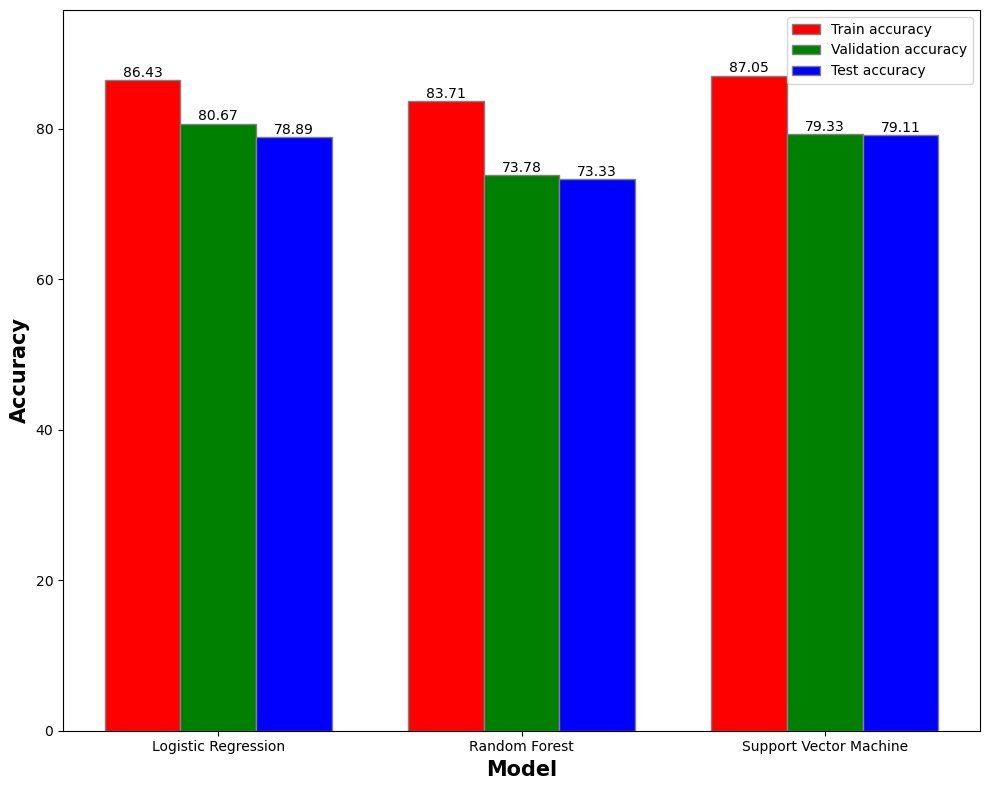

In [80]:
import matplotlib.pyplot as plt
import numpy as np

barWidth = 0.25
fig, ax = plt.subplots(figsize=(10, 8))

br1 = np.arange(len(MODELS))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Create bars
bars1 = plt.bar(br1, TRAIN_ACC, label='Train accuracy', color='r', width=barWidth, edgecolor='grey')
bars2 = plt.bar(br2, VALIDATION_ACC, label='Validation accuracy', color='g', width=barWidth, edgecolor='grey')
bars3 = plt.bar(br3, TEST_ACC, label='Test accuracy', color='b', width=barWidth, edgecolor='grey')


# Add value labels on bars
def autolabel(bars, values):
    """Attach a text label above each bar displaying its value."""
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                f'{value:.2f}',  # Format to 2 decimal places
                ha='center', va='bottom', fontsize=10)


# Add labels to each set of bars
autolabel(bars1, TRAIN_ACC)
autolabel(bars2, VALIDATION_ACC)
autolabel(bars3, TEST_ACC)

plt.xlabel('Model', fontweight='bold', fontsize=15)
plt.ylabel('Accuracy', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(MODELS))], MODELS)

# Adjust y-axis to make room for labels
plt.ylim(0, max(max(TRAIN_ACC), max(VALIDATION_ACC), max(TEST_ACC)) * 1.1)

plt.legend()
plt.tight_layout()
plt.show()

# **Pregunta - 11:**



Incluye tus comentarios finales de la actividad.

### ++++++++ Inicia la sección de agregar texto: +++++++++++

None

### ++++++++ Termina la sección de agregar texto: +++++++++++

# **Fin de la Actividad de Vectores Embebidos - OpenAI**